# Cell-Cell interaction Analysis using NCEM  
### Spatial pancreas  
Subset of a non-diabetic slide (fov == 12) 

### Pre-requisites

In [1]:
import seaborn as sns
import pandas as pd
import numpy as np

import scanpy as sc
import squidpy as sq
import ncem as nc

import matplotlib.pyplot as plt

sc.settings.set_figure_params(dpi=80, facecolor="white")

2024-06-26 20:49:38.318368: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-06-26 20:49:39.022410: I external/local_tsl/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2024-06-26 20:49:51.167430: I external/local_tsl/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2024-06-26 20:50:11.509970: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-06-26 20:51:15.028431: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF

In [2]:
nc.__version__

'0.1.5'

### Load data

In [3]:
folder = '/lustre/groups/ml01/workspace/sara.jimenez/spatial_pancreas_data/preprocessed_data/data4downstream/'
file   = 'adata_sp_fov_12.h5ad' #'imputed_envi.h5ad'
adata = sc.read(filename = folder + file)
adata

/home/aih/sara.jimenez/miniconda3/envs/ncem/lib/python3.9/site-packages/anndata/__init__.py:55: FutureWarning: `anndata.read` is deprecated, use `anndata.read_h5ad` instead. `ad.read` will be removed in mid 2024.
  warnings.warn(


AnnData object with n_obs × n_vars = 5208 × 979
    obs: 'fov', 'Area', 'AspectRatio', 'CenterX_global_px', 'CenterY_global_px', 'Width', 'Height', 'Mean.MembraneStain', 'Max.MembraneStain', 'Mean.PanCK', 'Max.PanCK', 'Mean.GCG', 'Max.GCG', 'Mean.CD3', 'Max.CD3', 'Mean.DAPI', 'Max.DAPI', 'cell_ID', 'condition', 'slide', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes', 'total_counts_NegPrb', 'log1p_total_counts_NegPrb', 'pct_counts_NegPrb', 'n_genes', 'cell_type_coarse', 'cell_type', 'leiden'
    var: 'NegPrb', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts', 'n_cells'
    uns: 'cell_type_coarse_colors', 'cell_type_colors', 'leiden', 'leiden_colors', 'log1p', 'neighbors', 'pca', 'spatial', 'umap'
    obsm: 'X_pca', 'X_umap', 'spatial', 'spatial_fov'
    varm: 

In [4]:
adata.obs['cell_type'].cat.categories

Index(['Acinar', 'Alpha', 'Beta', 'Ductal', 'Endocrine', 'Endothelial',
       'Fibroblasts', 'Immune'],
      dtype='object')

### Data Exploration

/home/aih/sara.jimenez/miniconda3/envs/ncem/lib/python3.9/site-packages/squidpy/pl/_spatial_utils.py:483: FutureWarning: The default value of 'ignore' for the `na_action` parameter in pandas.Categorical.map is deprecated and will be changed to 'None' in a future version. Please set na_action to the desired value to avoid seeing this warning
  color_vector = color_source_vector.map(color_map)


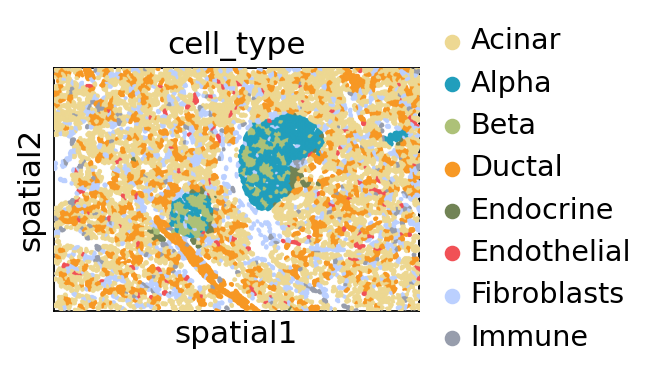

In [5]:
sq.pl.spatial_segment(adata,color='cell_type',ncols=2,
                      library_key='fov', seg_cell_id='cell_ID',cmap='RdYlBu_r', img=False)

In [7]:
from matplotlib.pyplot import rc_context

In [6]:
HORMONES = ['INS','GCG','SST']
#adata.uns['cell_type_coarse_colors'] = ['#00bbf9', '#a7c957', '#F4BA41', '#e63946', '#6c757d', '#ffcdb2','#fb8500']

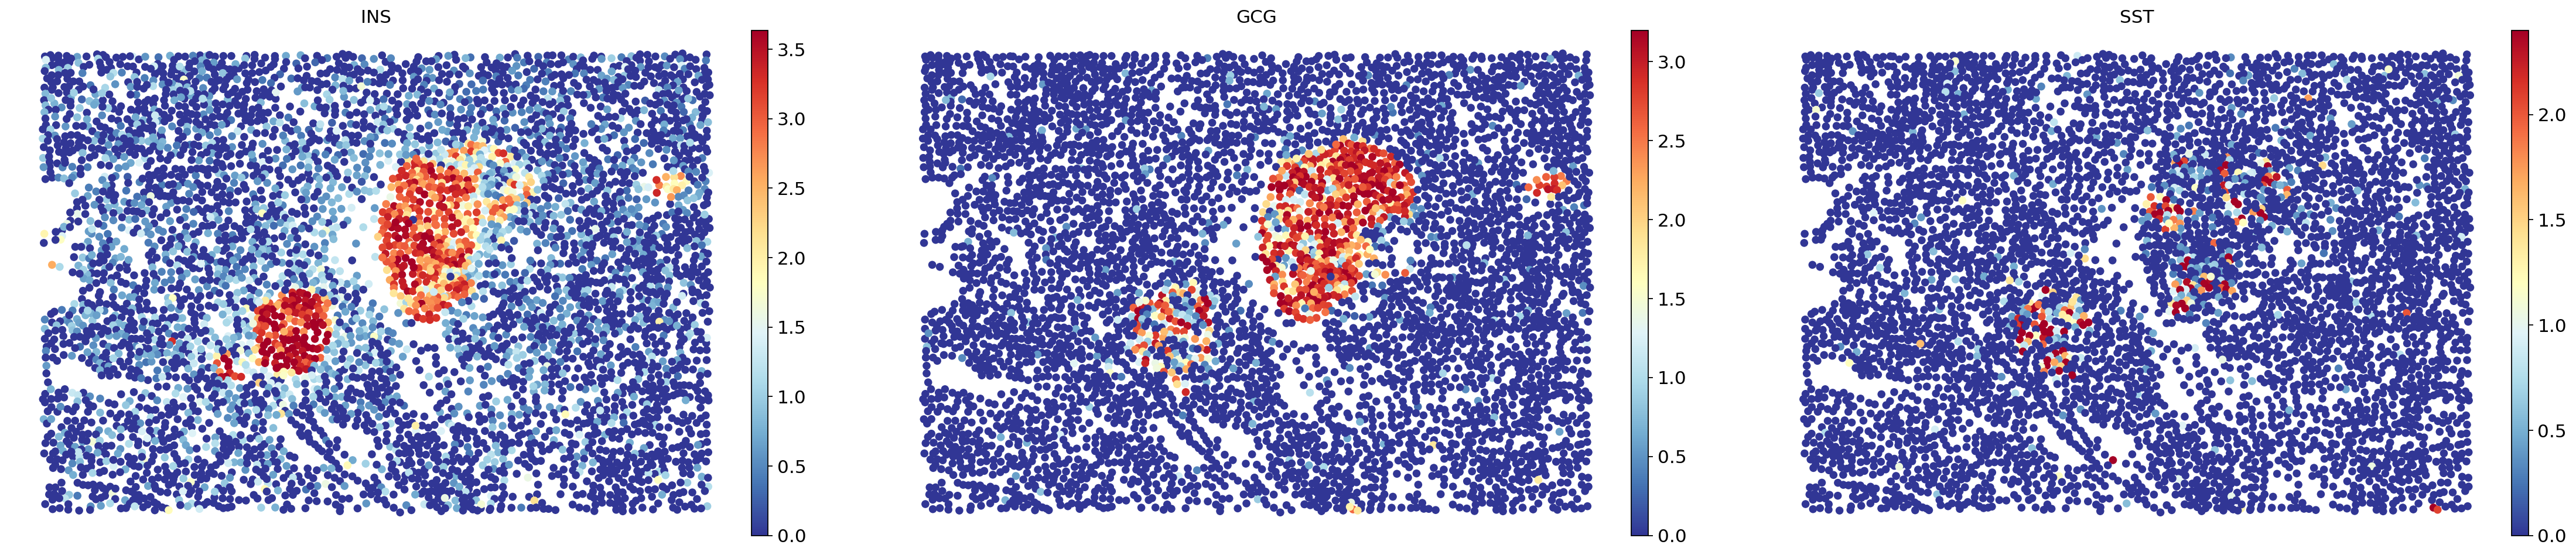

In [8]:
# Check expression of known markers to get intuition of the dataset
with rc_context({'figure.figsize': (10.5,7)}):
    sc.pl.embedding(
        adata,
        basis='spatial',
        color=HORMONES,
        vmin=0,
        vmax='p99',  
        sort_order=False,  
        frameon=False,
        cmap='RdYlBu_r', 
        size=150,ncols=3
    )

In [9]:
type(adata.X)

scipy.sparse._csr.csr_matrix

In [10]:
adata.X = adata.X.toarray()

1. Noise distribution of the dataset per cell type 
- NCEM requires gaussian distribution not negative binomial 
- Important not to overnormalized -> the 

Acinar
Alpha
Beta
Ductal
Endocrine
Endothelial
Fibroblasts
Immune


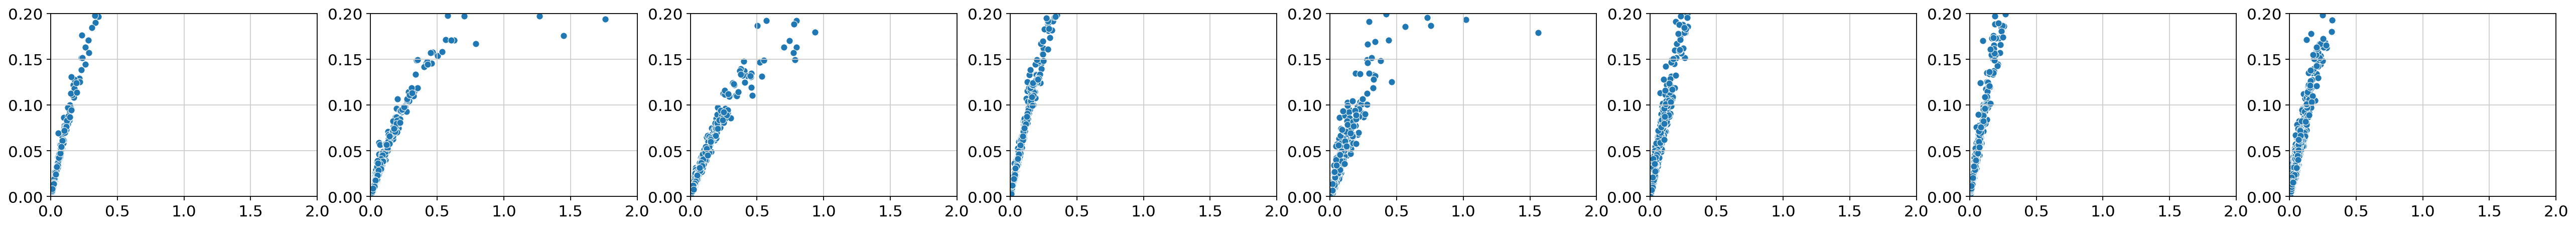

In [11]:
fig, ax = plt.subplots(1,len(np.unique(adata.obs['cell_type'])), figsize=(40,3))
for i, ct in enumerate(np.unique(adata.obs['cell_type'])):
    print(ct)
    mean = np.mean(adata[adata.obs['cell_type']==ct].X, axis=0)
    var = np.var(adata[adata.obs['cell_type']==ct].X, axis=0)
    g=sns.scatterplot(x=mean, y=var, ax=ax[i])
    g.set(ylim=(0, 0.2), xlim=(0,2))

In [12]:
adata.obs['cell_type'].cat.categories

Index(['Acinar', 'Alpha', 'Beta', 'Ductal', 'Endocrine', 'Endothelial',
       'Fibroblasts', 'Immune'],
      dtype='object')

### Pre-processing

In [13]:
adata.X.max()

4.3965755

In [14]:
adata.layers['counts'].max()

177

#### the data seems normalized
sc.pp.normalize_total(adata, inplace=True)
sc.pp.log1p(adata)
adata.X

In [15]:
# calculating node degree for several distances 
for rd in [0,35,50,110,180,500]:
    connectivities, _ = sq.gr.spatial_neighbors(
        adata, radius=rd, coord_type='generic', copy=True
    )
    print(np.mean(np.sum(connectivities, axis=0)))

0.0
0.23732718894009217
1.2645929339477726
9.872119815668203
26.92089093701997
192.69009216589862


In [16]:
sq.gr.spatial_neighbors(
    adata,
    n_neighs=15,
    coord_type="generic",
    delaunay=True,
)

/home/aih/sara.jimenez/miniconda3/envs/ncem/lib/python3.9/site-packages/squidpy/pl/_color_utils.py:27: ImplicitModificationWarning: Trying to modify attribute `._uns` of view, initializing view as actual.
  target.uns[color_key] = source.uns[color_key]
/home/aih/sara.jimenez/miniconda3/envs/ncem/lib/python3.9/site-packages/squidpy/pl/_spatial_utils.py:483: FutureWarning: The default value of 'ignore' for the `na_action` parameter in pandas.Categorical.map is deprecated and will be changed to 'None' in a future version. Please set na_action to the desired value to avoid seeing this warning
  color_vector = color_source_vector.map(color_map)


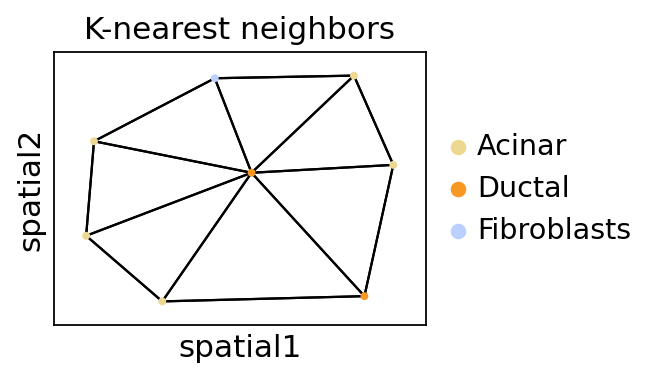

In [17]:
_, idx = adata.obsp["spatial_connectivities"][420, :].nonzero()
idx = np.append(idx, 420)
sq.pl.spatial_scatter(
    adata[idx,420],
    library_id = '12',
    color="cell_type",
    connectivity_key="spatial_connectivities",
    size=3,
    edges_width=1,
    edges_color="black",
    img=False,
    title="K-nearest neighbors"
)

### Neighbors enrichment analysis

In [18]:
sq.gr.nhood_enrichment(adata,cluster_key='cell_type')

100%|██████████| 1000/1000 [00:02<00:00, 345.62/s]


/home/aih/sara.jimenez/miniconda3/envs/ncem/lib/python3.9/site-packages/anndata/_core/anndata.py:430: FutureWarning: The dtype argument is deprecated and will be removed in late 2024.
  warnings.warn(
/home/aih/sara.jimenez/miniconda3/envs/ncem/lib/python3.9/site-packages/squidpy/pl/_utils.py:557: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  row_labels = adata.obs[key][row_order]


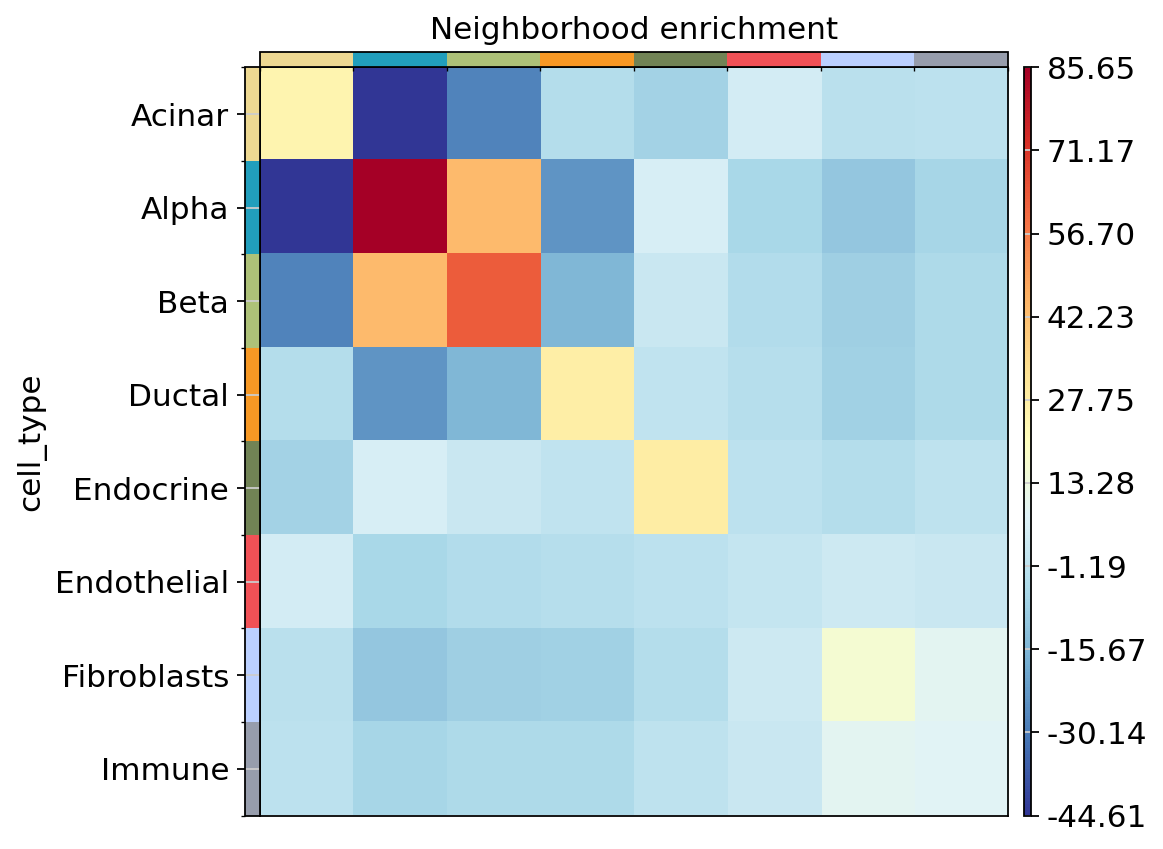

In [19]:
sq.pl.nhood_enrichment(adata, cluster_key='cell_type',cmap='RdYlBu_r',save='neig_enr.pdf')

In [20]:
sq.gr.interaction_matrix(adata, cluster_key='cell_type',weights=True)

/home/aih/sara.jimenez/miniconda3/envs/ncem/lib/python3.9/site-packages/anndata/_core/anndata.py:430: FutureWarning: The dtype argument is deprecated and will be removed in late 2024.
  warnings.warn(
/home/aih/sara.jimenez/miniconda3/envs/ncem/lib/python3.9/site-packages/squidpy/pl/_utils.py:557: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  row_labels = adata.obs[key][row_order]


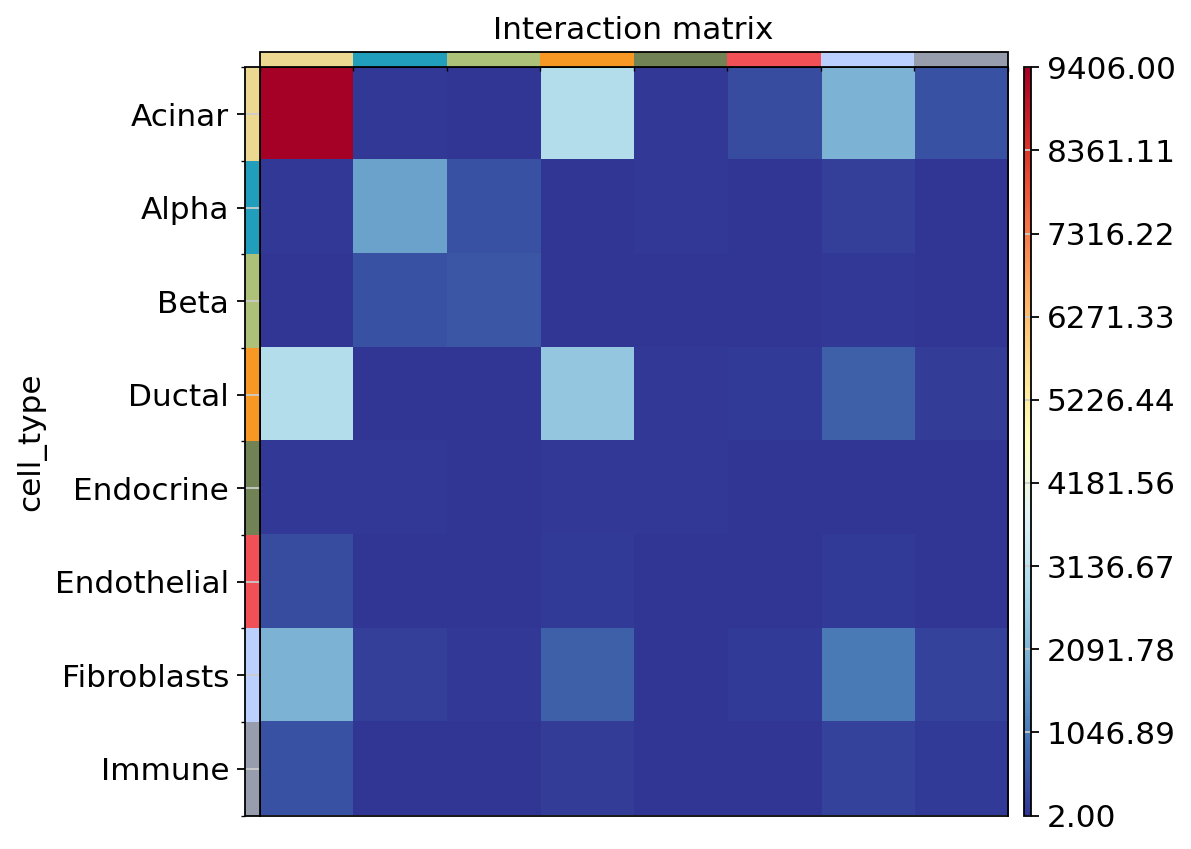

In [21]:
sq.pl.interaction_matrix(adata, cluster_key='cell_type',cmap='RdYlBu_r')

### Compute Ripley’s statistics
The Ripley’s L function is a descriptive statistics generally used to determine whether points have a random, dispersed or clustered distribution pattern at certain scale.

/home/aih/sara.jimenez/miniconda3/envs/ncem/lib/python3.9/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/home/aih/sara.jimenez/miniconda3/envs/ncem/lib/python3.9/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/home/aih/sara.jimenez/miniconda3/envs/ncem/lib/python3.9/site-packages/seaborn/_oldcore.py:1057: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grouped_data = data.groupby(
/home/aih/sara.jimenez/miniconda3/envs/ncem/l

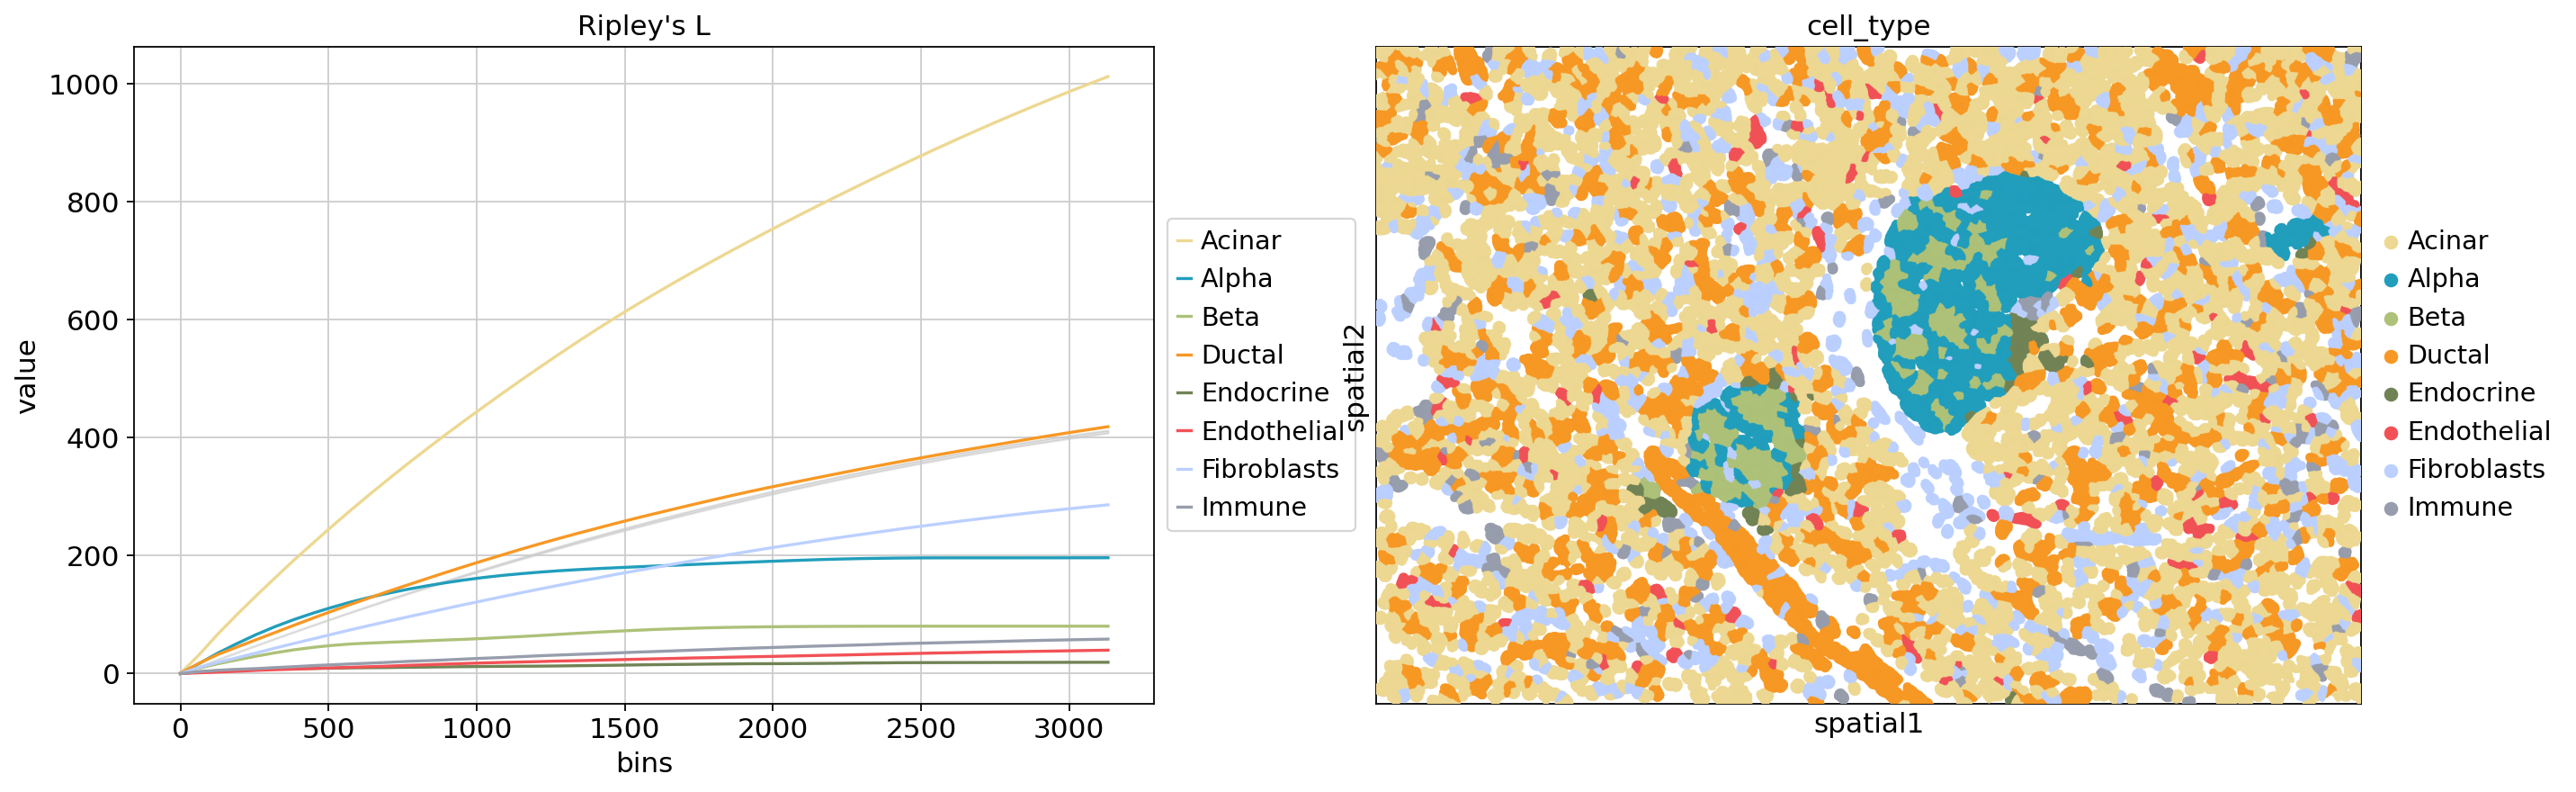

In [23]:
mode = "L"
fig, ax = plt.subplots(1, 2, figsize=(20, 6))

sq.gr.ripley(adata, cluster_key="cell_type", mode=mode)
sq.pl.ripley(
    adata,
    cluster_key="cell_type",
    mode=mode,
    ax=ax[0],
)

sq.pl.spatial_segment(
    adata,
    shape="hex",
    color="cell_type",
    library_id="12",
    library_key="fov",
    seg_cell_id="cell_ID",
    img=False,
    size=60,
    ax=ax[1],
)

### Moran’s I score

The Moran’s I global spatial auto-correlation statistics evaluates whether features (i.e. genes) shows a pattern that is clustered, dispersed or random in the tissue are under consideration.

In [24]:
#sq.gr.spatial_neighbors(adata, coord_type="generic", delaunay=True)
sq.gr.spatial_autocorr(
    adata,
    mode="moran",
    n_perms=100,
    n_jobs=1,
)
adata.uns["moranI"].head(10)

100%|██████████| 100/100 [00:23<00:00,  4.25/s]


I  pval_norm  var_norm  pval_z_sim  pval_sim   var_sim  \
TTR     0.841436        0.0  0.000065         0.0  0.009901  0.000152   
GCG     0.813863        0.0  0.000065         0.0  0.009901  0.000149   
CHGA    0.765895        0.0  0.000065         0.0  0.009901  0.000141   
INS     0.757733        0.0  0.000065         0.0  0.009901  0.000117   
PRSS2   0.732667        0.0  0.000065         0.0  0.009901  0.000103   
REG1A   0.714490        0.0  0.000065         0.0  0.009901  0.000104   
CPB1    0.674632        0.0  0.000065         0.0  0.009901  0.000105   
SPINK1  0.551265        0.0  0.000065         0.0  0.009901  0.000094   
IAPP    0.515339        0.0  0.000065         0.0  0.009901  0.000114   
SCG5    0.422968        0.0  0.000065         0.0  0.009901  0.000084   

        pval_norm_fdr_bh  pval_z_sim_fdr_bh  pval_sim_fdr_bh  
TTR                  0.0                0.0         0.028178  
GCG                  0.0                0.0         0.028178  
CHGA                 0.0                0.0         0.028178  
INS                  0.0                0.0         0.028178  
PRSS2                0.0                0.0         0.028178  
REG1A                0.0                0.0         0.028178  
CPB1                 0.0                0.0         0.028178  
SPINK1               0.0                0.0         0.028178  
IAPP                 0.0                0.0         0.028178  
SCG5                 0.0                0.0         0.028178

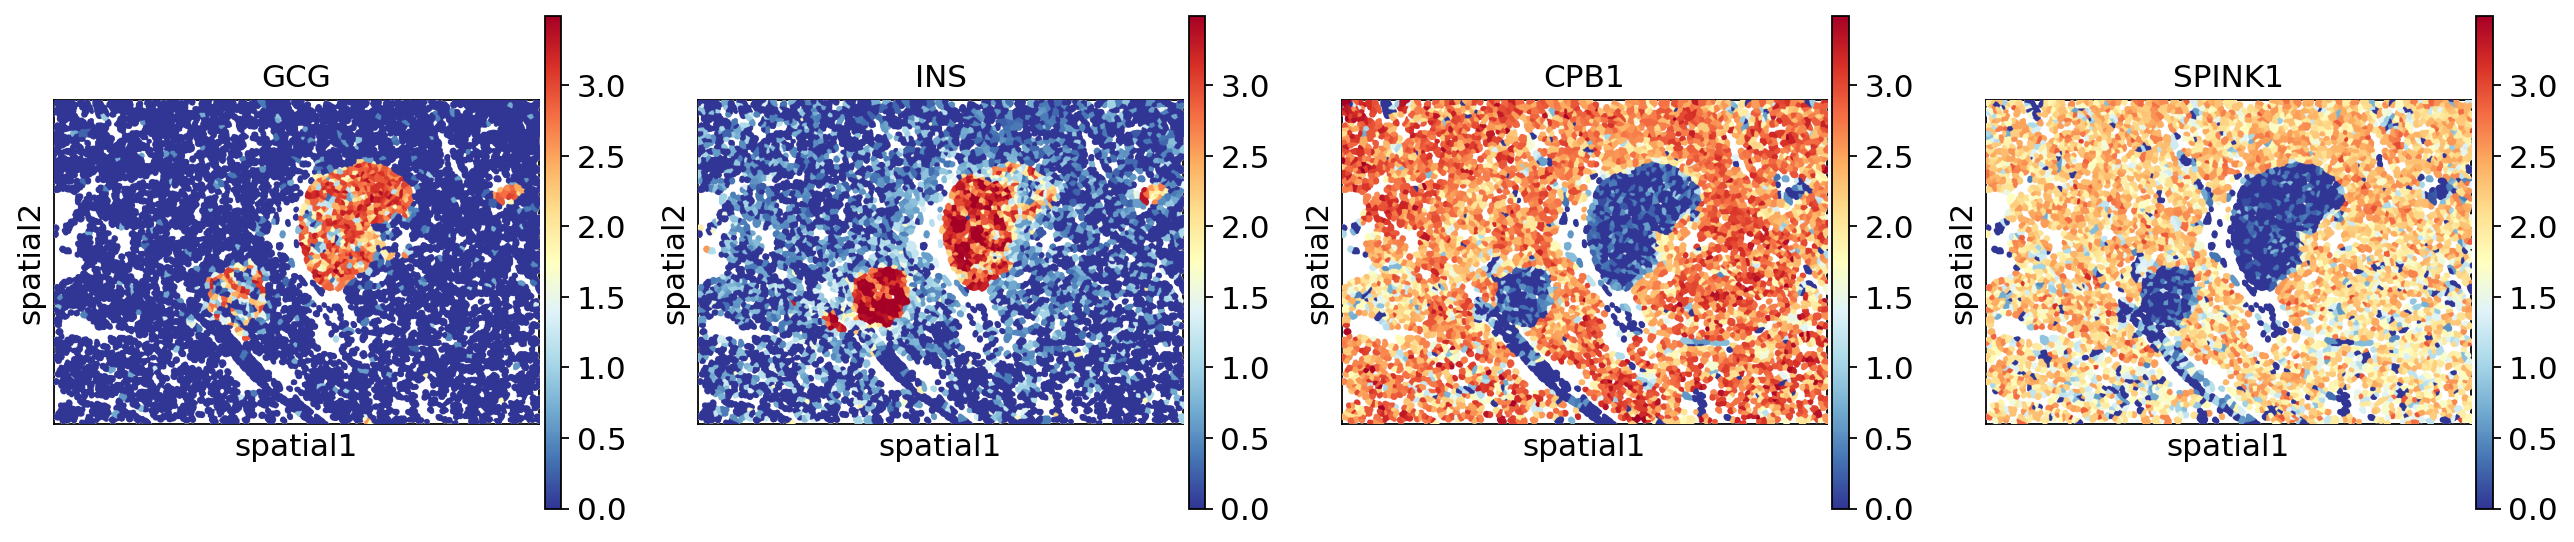

In [26]:
sq.pl.spatial_segment(
    adata,
    library_id="12",
    seg_cell_id="cell_ID",
    library_key="fov",
    color=["GCG", "INS", "CPB1","SPINK1"],
    size=60,
    img=False,cmap="RdYlBu_r"
)

### Ligand receptor analysis

In [31]:
sq.gr.ligrec(adata,cluster_key='cell_type',use_raw=False, alpha=0.005)

/home/aih/sara.jimenez/miniconda3/envs/ncem/lib/python3.9/site-packages/squidpy/gr/_ligrec.py:733: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  groups = data.groupby("clusters")
100%|██████████| 1000/1000 [00:01<00:00, 502.41permutation/s]


/home/aih/sara.jimenez/miniconda3/envs/ncem/lib/python3.9/site-packages/squidpy/pl/_ligrec.py:306: FutureWarning: DataFrame.groupby with axis=1 is deprecated. Do `frame.T.groupby(...)` without axis instead.
  for cls, size in (pvals.groupby(level=0, axis=1)).size().to_dict().items():
/home/aih/sara.jimenez/miniconda3/envs/ncem/lib/python3.9/site-packages/anndata/_core/anndata.py:430: FutureWarning: The dtype argument is deprecated and will be removed in late 2024.
  warnings.warn(
/home/aih/sara.jimenez/miniconda3/envs/ncem/lib/python3.9/site-packages/scanpy/plotting/_dotplot.py:747: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap', 'norm' will be ignored
  dot_ax.scatter(x, y, **kwds)


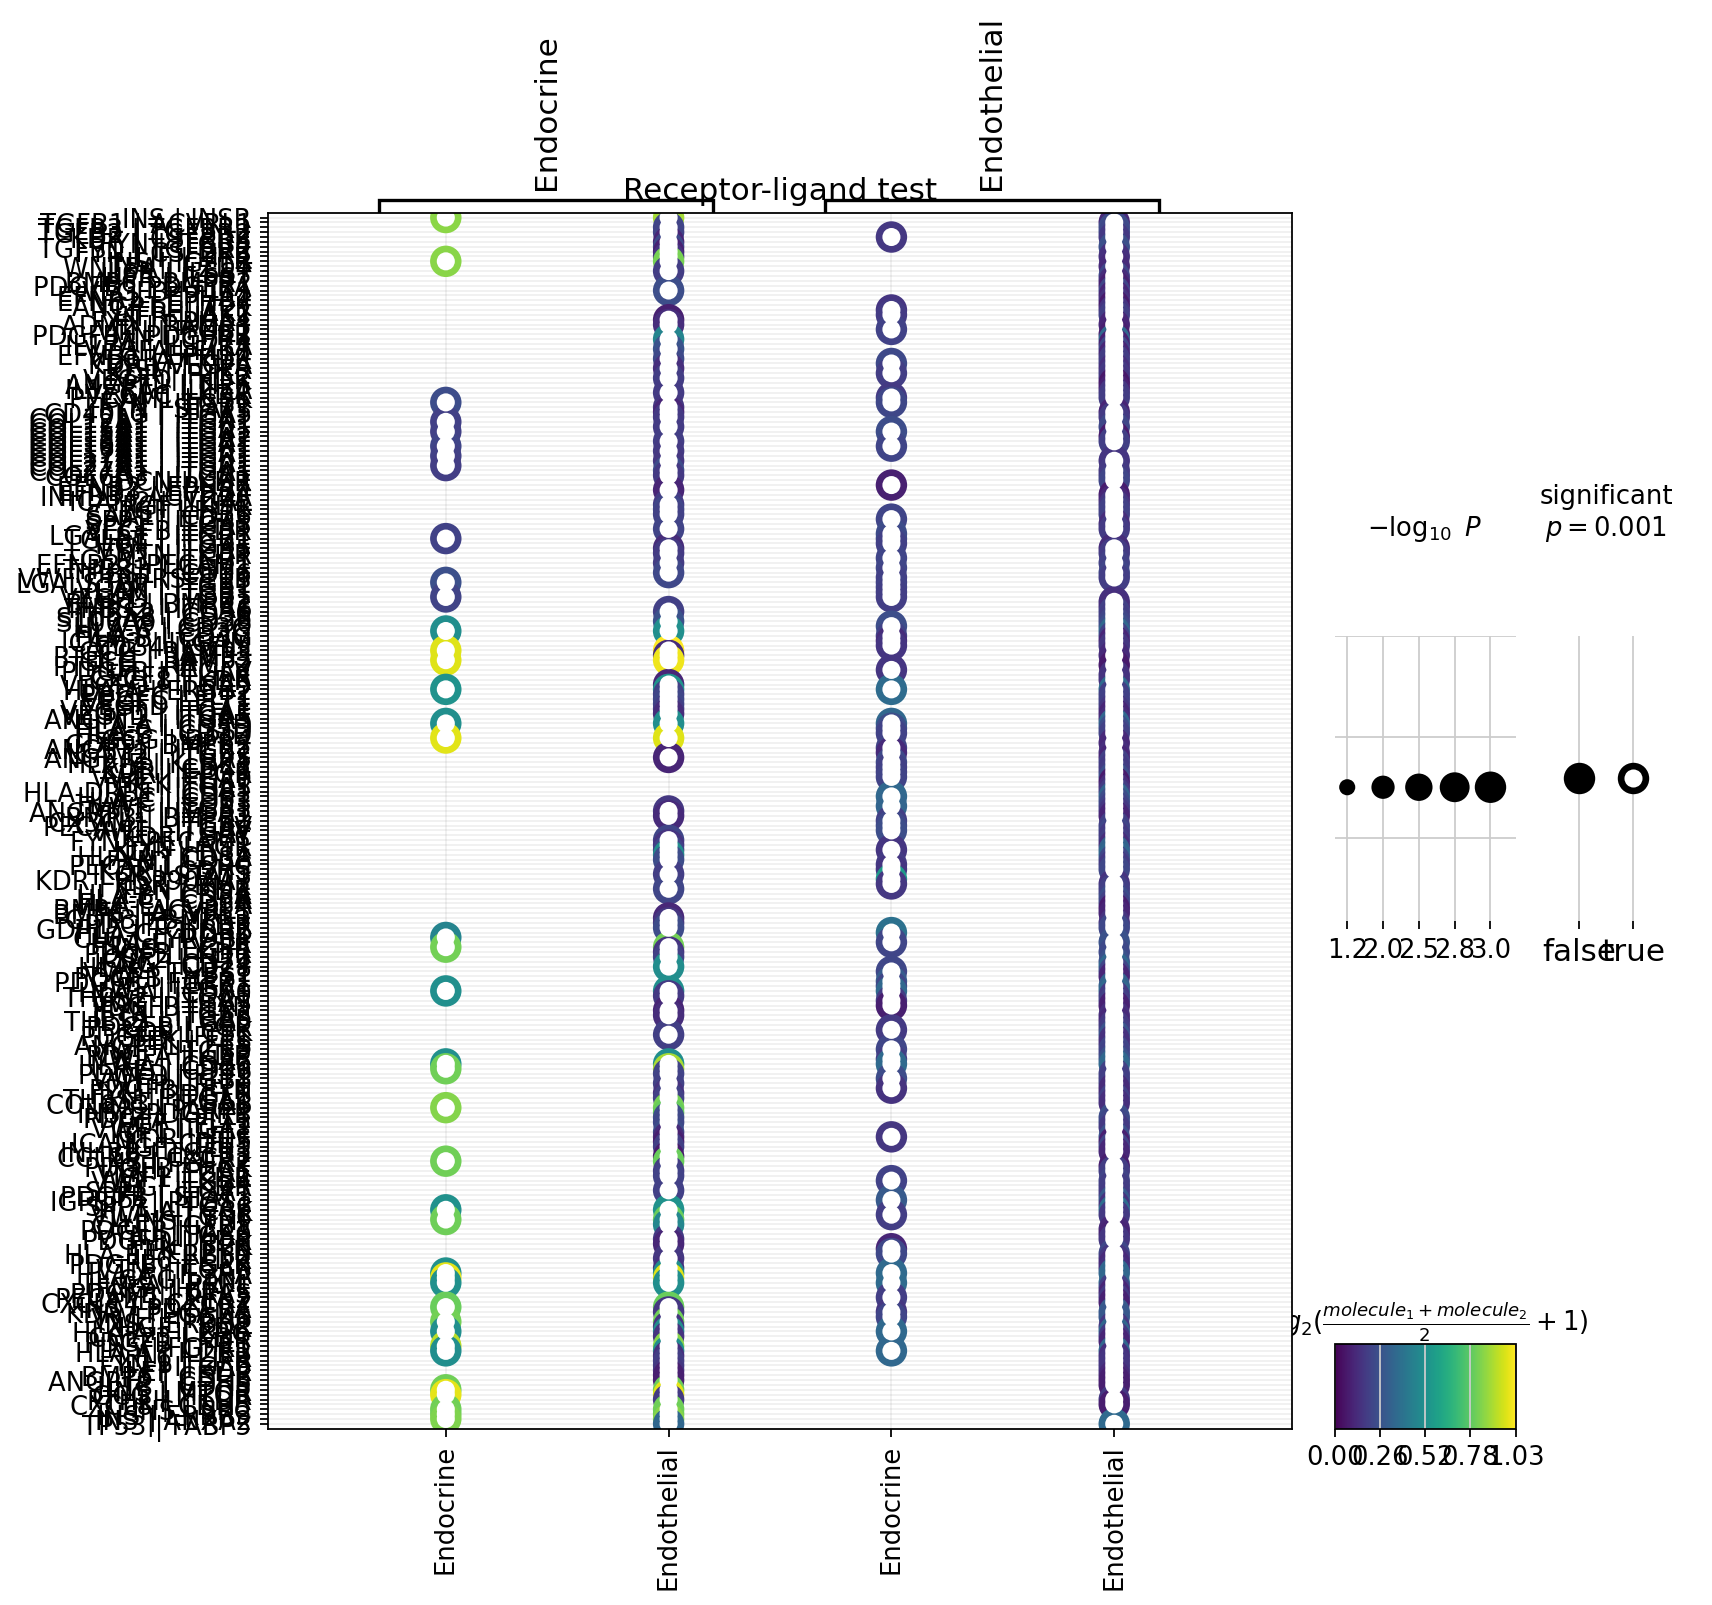

In [32]:
sq.pl.ligrec(adata, cluster_key='cell_type',pvalue_threshold=0.0001,
             remove_nonsig_interactions=True, remove_empty_interactions=True,figsize = (10,10))

### NCEM

In [33]:
from ncem.tl.fit.glm import linear_ncem

In [ ]:
linear_ncem

In [34]:
adata = linear_ncem(adata=adata, key_type='cell_type', key_graph='spatial_connectivities')

/home/aih/sara.jimenez/miniconda3/envs/ncem/lib/python3.9/site-packages/scipy/sparse/_index.py:146: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)


In [35]:
adata.obs['cell_type'].cat.categories

Index(['Acinar', 'Alpha', 'Beta', 'Ductal', 'Endocrine', 'Endothelial',
       'Fibroblasts', 'Immune'],
      dtype='object')

In [36]:
adata

AnnData object with n_obs × n_vars = 5208 × 979
    obs: 'fov', 'Area', 'AspectRatio', 'CenterX_global_px', 'CenterY_global_px', 'Width', 'Height', 'Mean.MembraneStain', 'Max.MembraneStain', 'Mean.PanCK', 'Max.PanCK', 'Mean.GCG', 'Max.GCG', 'Mean.CD3', 'Max.CD3', 'Mean.DAPI', 'Max.DAPI', 'cell_ID', 'condition', 'slide', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes', 'total_counts_NegPrb', 'log1p_total_counts_NegPrb', 'pct_counts_NegPrb', 'n_genes', 'cell_type_coarse', 'cell_type', 'leiden'
    var: 'NegPrb', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts', 'n_cells'
    uns: 'cell_type_coarse_colors', 'cell_type_colors', 'leiden', 'leiden_colors', 'log1p', 'neighbors', 'pca', 'spatial', 'umap', 'spatial_neighbors', 'cell_type_nhood_enrichment', 'cell_type_i

#### Exploring interesting interactions

In [112]:
adata.varm['ncem_params']

index_Acinar  index_Alpha  index_Beta  index_Ductal  \
AATK          0.070231    -0.048840    0.111047      0.042036   
ABL1          0.031466    -0.055774    0.040607      0.094867   
ABL2          0.107593     0.073098    0.033578      0.014304   
ACE           0.000493     0.009378    0.051176     -0.004685   
ACE2         -0.004698     0.034703    0.058374      0.052744   
...                ...          ...         ...           ...   
NegPrb19      0.031879     0.008829   -0.002683      0.036811   
NegPrb20     -0.007976     0.048128   -0.019710      0.080426   
NegPrb21     -0.001869    -0.014533   -0.018949     -0.010472   
NegPrb22     -0.004320    -0.012328   -0.018153     -0.001666   
NegPrb23      0.000375     0.017203    0.004516     -0.008169   

          index_Endocrine  index_Endothelial  index_Fibroblasts  index_Immune  \
AATK         1.203181e-02      -5.168469e-02           0.023251     -0.016298   
ABL1        -1.047814e-01       5.765550e-02           0.130002     -0.094162   
ABL2         1.045810e-01       1.443787e-01           0.057152      0.108628   
ACE          3.722463e-02       4.394607e-03           0.052365      0.010855   
ACE2         7.116503e-15      -2.677639e-03           0.056578      0.032960   
...                   ...                ...                ...           ...   
NegPrb19    -1.758198e-02       2.034464e-02           0.020400      0.028399   
NegPrb20     1.675277e-01      -4.181691e-02           0.012513      0.050224   
NegPrb21     1.813516e-15      -1.072041e-14           0.004697     -0.062868   
NegPrb22     1.184229e-01       3.259519e-02           0.008046     -0.015145   
NegPrb23    -1.154777e-14      -8.931795e-02           0.014552     -0.034522   

          index_Acinar:neighbor_Acinar  index_Alpha:neighbor_Acinar  ...  \
AATK                         -0.038125                    -0.054701  ...   
ABL1                         -0.003646                     0.031680  ...   
ABL2                          0.031331                     0.069788  ...   
ACE                           0.009184                     0.004755  ...   
ACE2                          0.016220                    -0.000383  ...   
...                                ...                          ...  ...   
NegPrb19                     -0.015303                     0.000959  ...   
NegPrb20                      0.025859                    -0.002610  ...   
NegPrb21                      0.010580                    -0.002750  ...   
NegPrb22                      0.023748                    -0.002202  ...   
NegPrb23                      0.008439                     0.008158  ...   

          index_Fibroblasts:neighbor_Fibroblasts  \
AATK                                   -0.009976   
ABL1                                    0.000128   
ABL2                                    0.005520   
ACE                                    -0.013509   
ACE2                                   -0.003305   
...                                          ...   
NegPrb19                                0.007556   
NegPrb20                               -0.003805   
NegPrb21                                0.002601   
NegPrb22                               -0.007892   
NegPrb23                               -0.005271   

          index_Immune:neighbor_Fibroblasts  index_Acinar:neighbor_Immune  \
AATK                              -0.002971                      0.011612   
ABL1                               0.065876                      0.003774   
ABL2                              -0.081220                     -0.025972   
ACE                                0.005465                      0.001172   
ACE2                               0.007686                     -0.007480   
...                                     ...                           ...   
NegPrb19                           0.014821                     -0.005054   
NegPrb20                          -0.002785                     -0.000773   
NegPrb21                 

In [106]:
#df = pd.DataFrame(np.sum(np.absolute(adata.varm['ncem_fdr_pvals']<0.05)))
df = pd.DataFrame(np.sum(np.absolute(adata.varm['ncem_params'])))
df_int = pd.DataFrame(columns=adata.obs['cell_type'].cat.categories, index=adata.obs['cell_type'].cat.categories,dtype=float)
for s in adata.obs['cell_type'].cat.categories:
    for r in adata.obs['cell_type'].cat.categories: 
        index_value = 'index_'+s+':neighbor_'+r
        df_int.at[s,r] = df.loc[index_value][0]
df_int

/home/aih/sara.jimenez/miniconda3/envs/ncem/lib/python3.9/site-packages/numpy/core/fromnumeric.py:84: FutureWarning: The behavior of DataFrame.sum with axis=None is deprecated, in a future version this will reduce over both axes and return a scalar. To retain the old behavior, pass axis=0 (or do not pass axis)
  return reduction(axis=axis, out=out, **passkwargs)


Acinar       Alpha        Beta     Ductal  Endocrine  \
Acinar       27.161045   19.605085   47.209778   4.937181  17.680399   
Alpha        21.940417  103.488248   15.552929  34.510080  23.432421   
Beta         65.041492   32.376728   48.931792  61.524156  45.058556   
Ductal       36.512573   39.436706   68.857323  18.844358  26.799393   
Endocrine    45.686379   40.442380   46.092177  46.910404  41.062810   
Endothelial  90.436455   91.215998   53.808843  30.190818  53.808843   
Fibroblasts  34.243946   33.519246   48.630444  13.605246  48.899987   
Immune       63.145875   66.754023  103.782349  28.649990  70.880822   

             Endothelial  Fibroblasts     Immune  
Acinar          6.772605     4.651438   7.365911  
Alpha          42.100777    13.150306  32.580719  
Beta           71.278916    22.412085  69.890257  
Ductal         15.088101     8.876824  14.119737  
Endocrine      87.824294    41.548583  57.568079  
Endothelial    42.670979    28.946647  35.259162  
Fibroblasts    16.740466    16.625185  17.581635  
Immune         36.373411    30.759904  26.428811

In [83]:
import seaborn as sns

<Axes: >

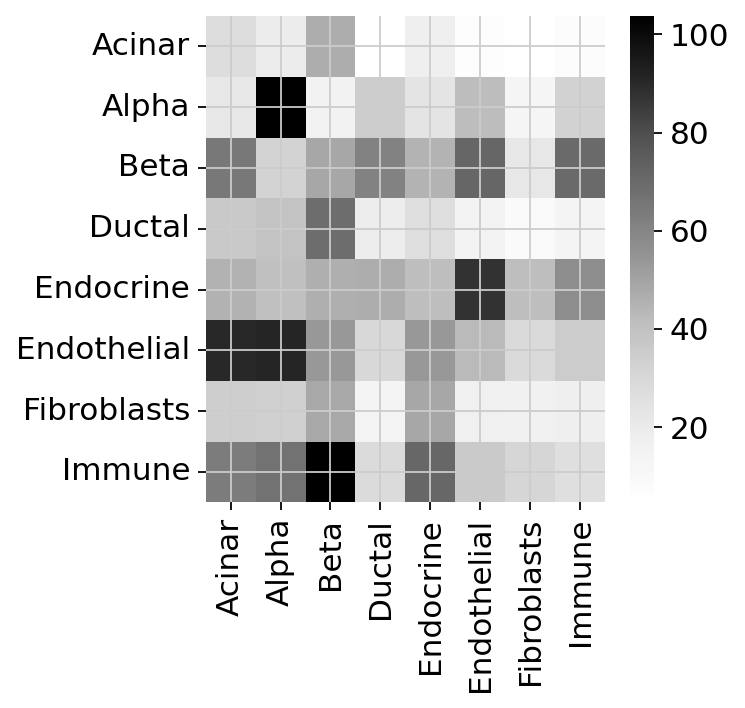

In [107]:
sns.heatmap(
            df_int,
            cmap="Greys",
        )

In [108]:
interactions = [
    'index_Alpha:neighbor_Alpha',
    'index_Endothelial:neighbor_Alpha'   
]

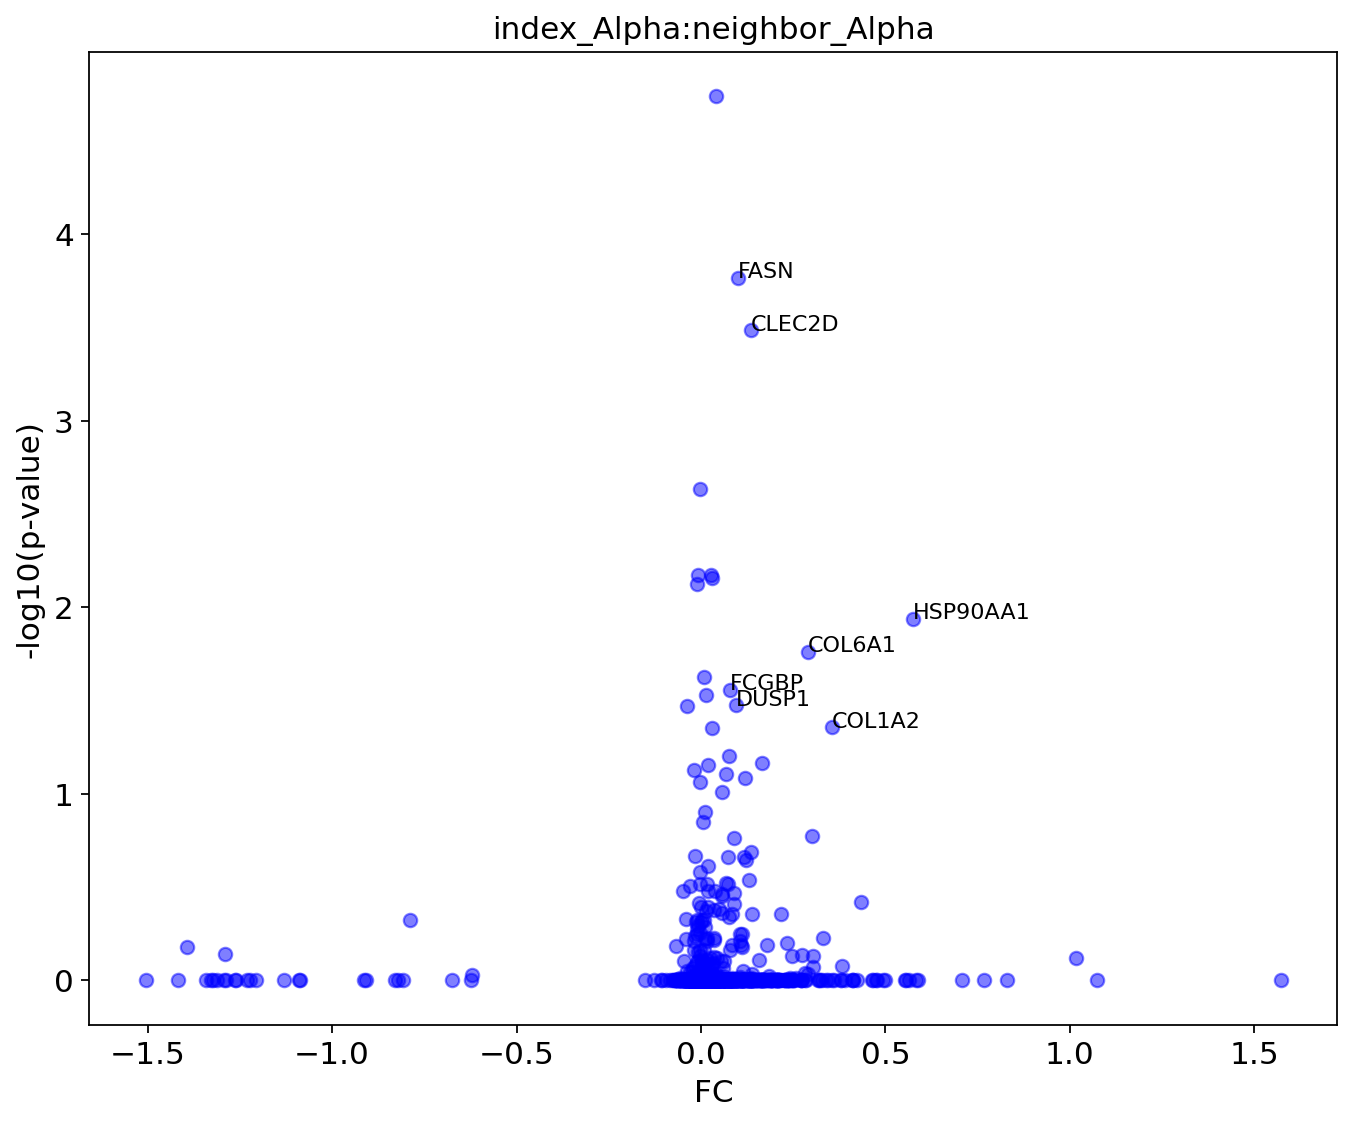

/home/aih/sara.jimenez/miniconda3/envs/ncem/lib/python3.9/site-packages/pandas/core/arraylike.py:399: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)


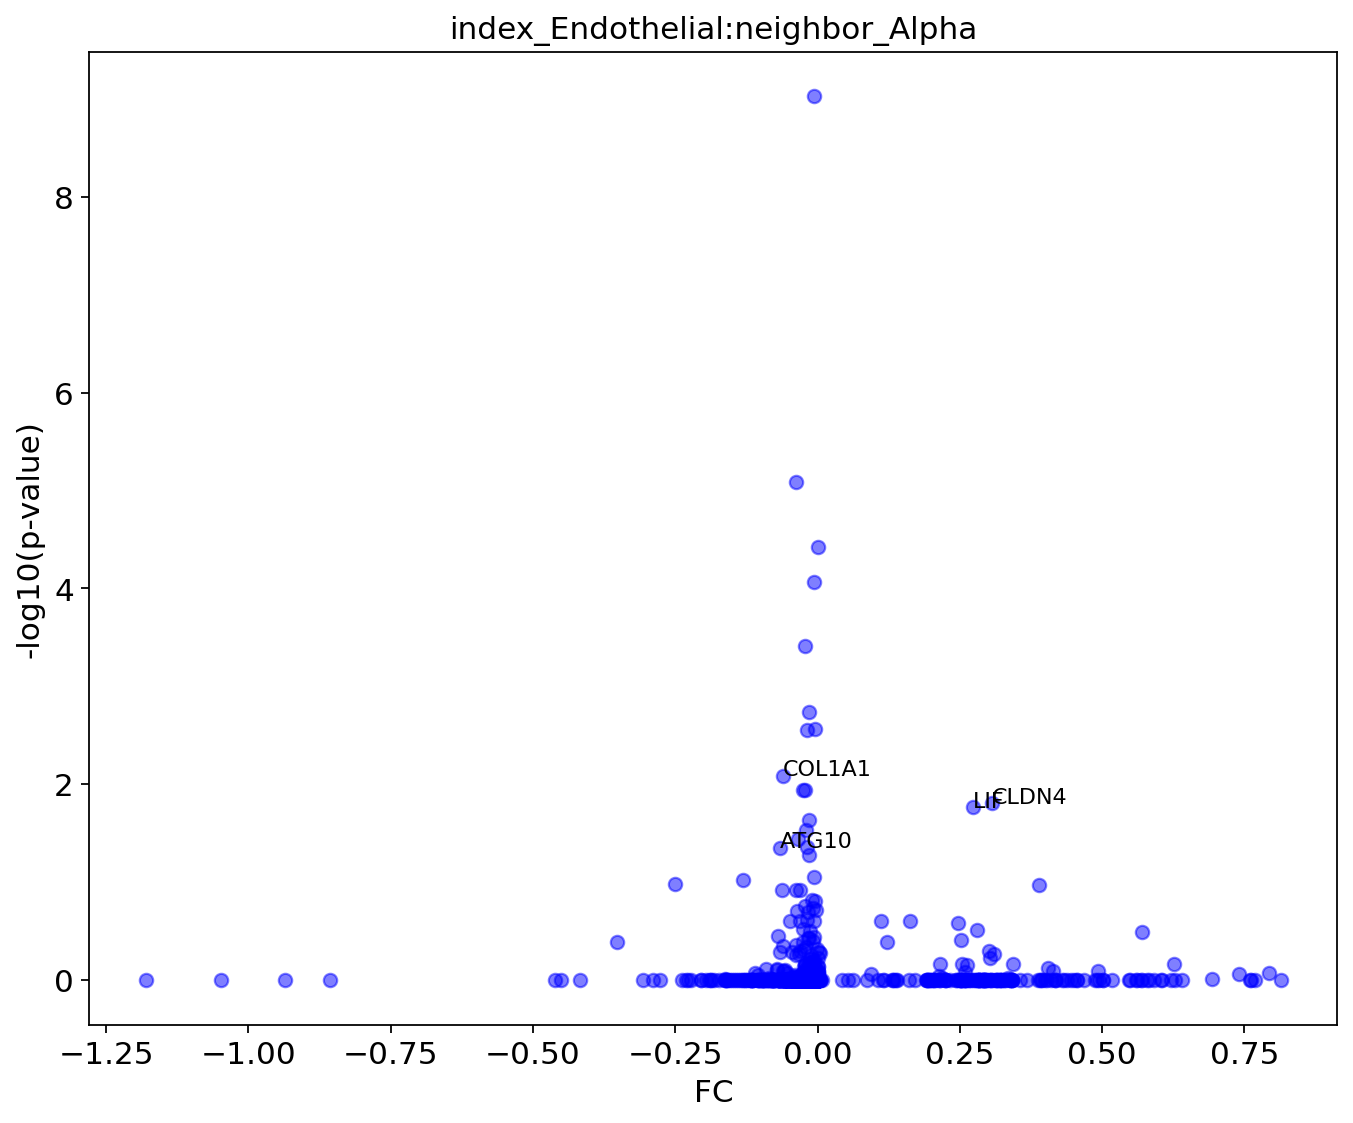

In [109]:
for c in interactions:
    data_df = {
        'log2FoldChange' : adata.varm['ncem_params'][c],
        'padj' : adata.varm['ncem_fdr_pvals'][c],
        'symbol' : np.array(adata.varm['ncem_fdr_pvals'].index)
    }
    
    df = pd.DataFrame(data_df)
    
    df['-log10(p_value)'] = -np.log10(df['padj'])
    

    plt.figure(figsize=(10, 8))
    plt.scatter(df['log2FoldChange'], df['-log10(p_value)'], color='blue', alpha=0.5)
    
    # Label the most significant points
    threshold_logFC = 0.05  # Adjust as needed
    threshold_p_value = 0.05  # Adjust as needed
    significant_points = df[(abs(df['log2FoldChange']) >= threshold_logFC) & (df['padj'] <= threshold_p_value)]
    for i, point in significant_points.iterrows():
        plt.text(point['log2FoldChange'], point['-log10(p_value)'], point['symbol'], fontsize=10)
        #volcano(df)
        
    # Add labels and title
    plt.xlabel('FC')
    plt.ylabel('-log10(p-value)')
    plt.title(c)
    
    # Show plot
    plt.grid(False)
    plt.show()

In [ ]:
data_df = {
    'FC' : adata.varm['ncem_params']['index_Beta:neighbor_Alpha'],
    'p_value' : adata.varm['ncem_fdr_pvals']['index_Beta:neighbor_Alpha'],
    'gene_names' : np.array(adata.varm['ncem_fdr_pvals'].index)
}

df = pd.DataFrame(data_df)
df

In [ ]:
# Create volcano plot
#df['-log10(p_value)'] = -df['p_value'].apply(lambda x: -1 * (x**10))
df['-log10(p_value)'] = -np.log10(df['p_value'])

plt.figure(figsize=(10, 8))
plt.scatter(df['FC'], df['-log10(p_value)'], color='blue', alpha=0.5)

# Label the most significant points
threshold_logFC = 0.05  # Adjust as needed
threshold_p_value = 0.05  # Adjust as needed
significant_points = df[(abs(df['FC']) >= threshold_logFC) & (df['p_value'] <= threshold_p_value)]
for i, point in significant_points.iterrows():
    plt.text(point['FC'], point['-log10(p_value)'], point['gene_names'], fontsize=10)

# Add labels and title
plt.xlabel('FC')
plt.ylabel('-log10(p-value)')
plt.title('index_Alpha:neighbor_Beta')

# Show plot
plt.grid(False)
plt.show()

In [110]:
alpha = 0.0001
np.sum(adata.varm['ncem_fdr_pvals'] < alpha) # and then sort

/home/aih/sara.jimenez/miniconda3/envs/ncem/lib/python3.9/site-packages/numpy/core/fromnumeric.py:84: FutureWarning: The behavior of DataFrame.sum with axis=None is deprecated, in a future version this will reduce over both axes and return a scalar. To retain the old behavior, pass axis=0 (or do not pass axis)
  return reduction(axis=axis, out=out, **passkwargs)


index_Acinar:neighbor_Acinar         6
index_Alpha:neighbor_Acinar          4
index_Beta:neighbor_Acinar           6
index_Ductal:neighbor_Acinar         3
index_Endocrine:neighbor_Acinar      2
                                    ..
index_Ductal:neighbor_Immune         3
index_Endocrine:neighbor_Immune      2
index_Endothelial:neighbor_Immune    5
index_Fibroblasts:neighbor_Immune    5
index_Immune:neighbor_Immune         5
Length: 64, dtype: int64

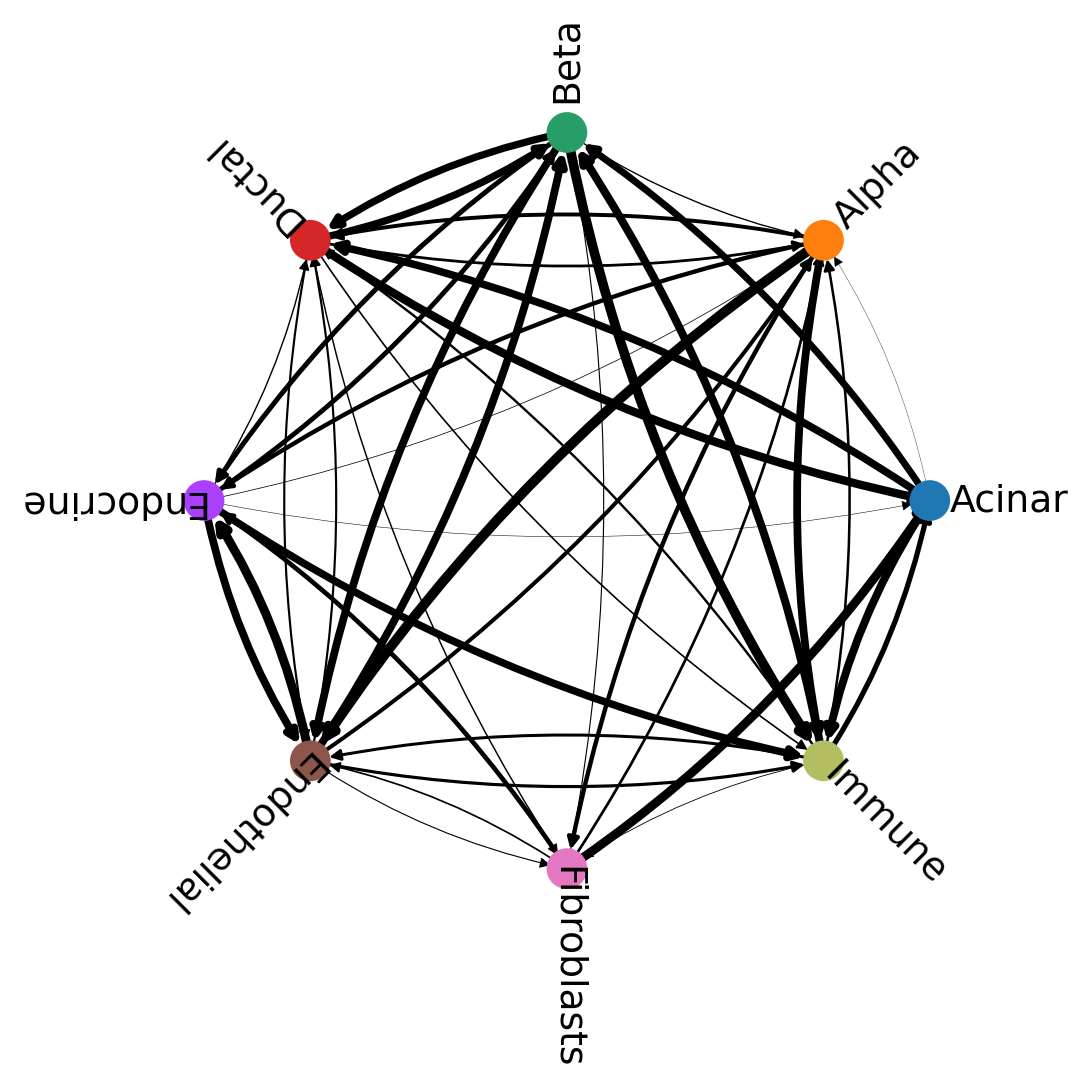

In [111]:
from ncem.pl.type_couplings import circular_rotated_labels
circular_rotated_labels(
    adata, 
    alpha=0.0001, # alpha is threshold when a p-value is considered significant (either 0.01, 0.05, 0.1)
    figsize=(7,7), 
    scale_edge=3, 
    params_key='ncem_params', 
    pvals_key='ncem_fdr_pvals', 
    edge_type='magnitude', # de_genes ior magnitude
    clip_edges=2.5 # this value is for plotting reasons --> smaller = more arrows
)

In [ ]:
circular_rotated_labels

In [ ]:
adata.obs.cell_type.cat.categories

In [ ]:
nc.pl.noise_structure(adata,cluster_key='cell_type',figsize=(15,15))

In [ ]:
nc.pl.cluster_freq(adata, cluster_key='cell_type')